# Factors Driving Austin Housing Prices
## Data Cleanup
Ricardo Dunia (duniarh)
<br/>
Kevin John Cherian Joseph (kc43529)
<br/>
Arnob Mallick (am93746)

In [31]:
import math
import seaborn as sns
import pandas as pd
import numpy as np

from datetime import date

In [32]:
# constants and config
today = date.today()

pd.set_option('display.max_columns', None)

In [33]:
# function for standardizing column names
def fix_column_names(df):
    cols = list(df)
    return df.rename(columns={ col: col.replace(' ', '_').lower() for col in cols })

In [34]:
# load the dataset
df = pd.read_csv('./data/raw_austin_housing_data_w_crime_density_poi_appraisals.csv')

## Inspect the data to see what we are working with
Perform data cleanup if necessary.

In [35]:
print('All columns in the raw data:')
print(list(df))

All columns in the raw data:
['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'id', 'baths', 'beds', 'city', 'daysOnMarket', 'hoa', 'latitude', 'longitude', 'lotSize', 'salePrice', 'pricePerSqFt', 'lastSaleDate', 'sqFt', 'state', 'stories', 'streetLine', 'yearBuilt', 'zip', 'Crime Index', 'idx', 'Population Density', 'park_index', 'schools_index', 'event_index', 'fastfood_index', 'Address', 'Number', '2015 Appraisal', '2019 Appraisal']


Looks like we have a few stray index columns to clean up. 

In [36]:
# remove useless index columns
df.drop(['id', 'idx'] + [ stray_index for stray_index in [ index for index in list(df) if index.startswith('Unnamed:')] ], axis=1, inplace=True)

print('Cleaned up columns: ')
print(list(df))

Cleaned up columns: 
['baths', 'beds', 'city', 'daysOnMarket', 'hoa', 'latitude', 'longitude', 'lotSize', 'salePrice', 'pricePerSqFt', 'lastSaleDate', 'sqFt', 'state', 'stories', 'streetLine', 'yearBuilt', 'zip', 'Crime Index', 'Population Density', 'park_index', 'schools_index', 'event_index', 'fastfood_index', 'Address', 'Number', '2015 Appraisal', '2019 Appraisal']


## Start cleaning up rows with missing data
How many rows are missing appraisal information?

In [37]:
# how many rows are missing appraisal information?
appraisal_threshold = 0
print('Total size of the data: ' + str(len(df)))
print('Rows missing or too low appraisals: ' + str(len(df[ (df['2015 Appraisal'] < appraisal_threshold) | (df['2019 Appraisal'] == appraisal_threshold) ])))

# remove rows
df = df[ (df['2015 Appraisal'] > appraisal_threshold) & (df['2019 Appraisal'] > appraisal_threshold) ]
print('Now we have ' + str(len(df)) + ' rows.')

Total size of the data: 61793
Rows missing or too low appraisals: 21157
Now we have 39653 rows.


## Compute the 5-year growth (or decline) of value

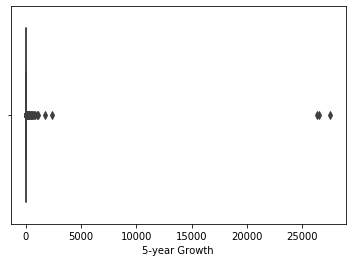

In [38]:
# compute 5-year growth
df['5-year Growth'] = df.apply(lambda row: (row['2019 Appraisal'] - row['2015 Appraisal']) / row['2015 Appraisal'], axis=1)

# visualize the distribution
sns.boxplot(x=df['5-year Growth'])

This doesn't look good. There is at least one property that has grown by ~2500000%. Let's remove some of the extreme outliers.

In [39]:
# function to remove extreme outliers
def remove_outliers(num_stds, df, column_name):
    growth_threshold_top = df[column_name].mean() + (df[column_name].std() * num_stds)
    growth_threshold_bot = df[column_name].mean() - (df[column_name].std() * num_stds)
    purged_df = df[ (df[column_name] < growth_threshold_top) & 
                    (df[column_name] > growth_threshold_bot) ]

    sns.boxplot(x=purged_df[column_name])
    return purged_df

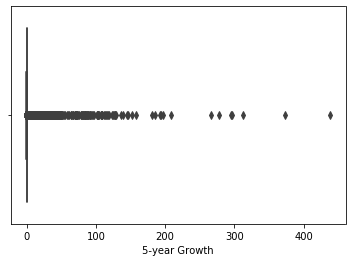

In [40]:
# first pass of removing outliers
df = remove_outliers(2, df, '5-year Growth')

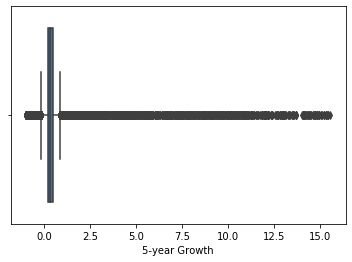

In [41]:
# try again
df = remove_outliers(2, df, '5-year Growth')

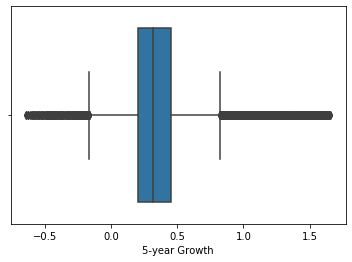

In [42]:
# try once more with a more strict cutoff
df = remove_outliers(1, df, '5-year Growth')

Okay... this is finally looking much more acceptable, we can start working with this.

## Clean-up

We still need to address the other columns though. Let's go through that now.

In [43]:
# Fix float representation of zips
df['zip'] = df['zip'].apply(lambda x: str(int(x)))

In [44]:
# Eliminate rows with no #Beds, no #Baths, no yearBuilt, no Sqft
print(len(df))
df = df.loc[df['beds'] > 0]
print(len(df))
df = df.loc[df['baths'] > 0]
print(len(df))
df = df.loc[df['yearBuilt'] > 0]
print(len(df))
df = df.loc[df['sqFt'] > 0]
print(len(df))

37926
31616
31610
31607
30784


In [45]:
# Define lat/lon limit square
min_lat = 30.0727239
max_lat = 30.5193782
min_lon = -98.0158212
max_lon = -97.4053586
df = df.drop(df[(df['latitude'] < min_lat)].index)
df = df.drop(df[(df['latitude'] > max_lat)].index)
df = df.drop(df[(df['longitude'] < min_lon)].index)
df = df.drop(df[(df['longitude'] > max_lon)].index)
print(len(df))   

29803


In [46]:
# Add column days between selling date and built date
# Eliminate column 'yearBuilt'
YB = df['yearBuilt']
subYB = []
for aYB in YB :
    dYB = date(int(aYB), 1, 1)
    delta = today - dYB
    subYB.append(delta.days)
df.rename(columns={'yearBuilt':'daysBtwBldAndSold'}, inplace=True)    
df['daysBtwBldAndSold'] = subYB

In [47]:
# Add column days between selling date and today
# Eliminate column 'lastSaleDate'
DS = df['lastSaleDate']
subDS = []
for aDS in DS :
    aDS = pd.to_datetime(aDS)
    delta = today - aDS.date()
    subDS.append(delta.days)
df.rename(columns={'lastSaleDate':'daysAftSold'}, inplace=True)    
df['daysAftSold'] = subDS

In [48]:
# Compute age of home by combining 'datsBtwBldAndSold' and 'daysAftSold'
df['house_age'] = df['daysBtwBldAndSold'] + df['daysAftSold']

In [49]:
# If lot size is missing, consider sqF times 3
LS = df['lotSize']
SQF = df['sqFt']
subLS = []
i = 0
for aLS in LS :
    if aLS > 0 :
        subLS.append(aLS) 
    else :
        temp = 3 * SQF.iloc[i]
        subLS.append(temp)
    i += 1
df['lotSize'] = subLS

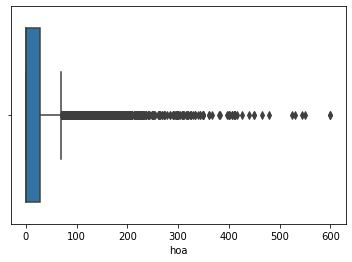

In [50]:
# If HOA is empty, fill it with zero
df['hoa'] = df['hoa'].fillna(0)
df = remove_outliers(1, df, 'hoa')

At a glance it looks like most properties in Austin either don't have an HOA fee or they don't report an HOA fee in their listing.

29711


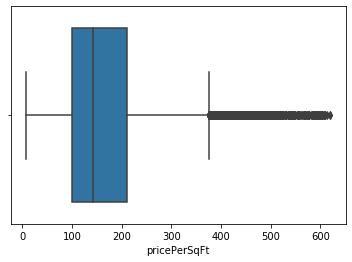

In [51]:
# Clean up pricePerSqft
df = remove_outliers(0.5, df, 'pricePerSqFt')
print(len(df))

28898


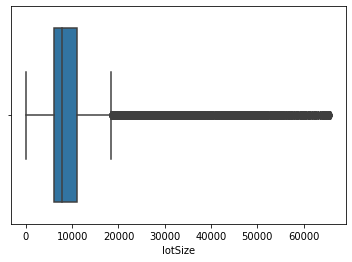

In [52]:
# Clean up lotSize 
df = remove_outliers(1, df, 'lotSize')
df = df[df['lotSize'] > 1000]
print(len(df))

28786


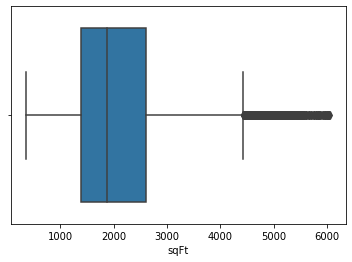

In [53]:
# Clean up sqft
df = remove_outliers(4, df, 'sqFt')
print(len(df))

In [54]:
# change stories to one-hot
df_temp = pd.get_dummies(df['stories'], 'stories')
df_temp.drop([col for col, val in df_temp.sum().iteritems() if val < 500], axis=1, inplace=True)

df = pd.concat([df, df_temp],axis = 1)
df = df.drop('stories',axis = 1)
df = df[ df[ [col for col in list(df) if col.startswith('stories_')] ].sum(axis=1) != 0 ]
print(len(df))

28396


In [55]:
# change baths to one-hot
df_temp = pd.get_dummies(df['beds'], 'beds')
df_temp.drop([col for col, val in df_temp.sum().iteritems() if val < 500], axis=1, inplace=True)

df = pd.concat([df, df_temp],axis = 1)
df = df.drop('beds',axis = 1)
df = df[ df[ [col for col in list(df) if col.startswith('beds_')] ].sum(axis=1) != 0 ]
print(len(df))

28101


In [56]:
# change beds to one-hot
df_temp = pd.get_dummies(df['baths'], 'baths')
df_temp.drop([col for col, val in df_temp.sum().iteritems() if val < 500], axis=1, inplace=True)

df = pd.concat([df, df_temp],axis = 1)
df = df.drop('baths',axis = 1)
df = df[ df[ [col for col in list(df) if col.startswith('baths_')] ].sum(axis=1) != 0 ]
print(len(df))

27372


In [57]:
# change zip to one-hot
df_temp = pd.get_dummies(df['zip'], 'zip')
df_temp.drop([col for col, val in df_temp.sum().iteritems() if val < 500], axis=1, inplace=True)

df = pd.concat([df, df_temp],axis = 1)
df = df[ df[ [col for col in list(df) if col.startswith('zip_')] ].sum(axis=1) != 0 ]
print(len(df))

24548


In [58]:
# Remove nans
df.dropna(inplace=True)
df = df[~df.isin([np.inf, -np.inf])]
print(len(df))

24384


## Scale location sensitive data by Population Density

In [59]:
df['Crime Index Scaled'] = df['Crime Index'] / df['Population Density']
df['park_index_scaled'] = df['park_index'] / df['Population Density']
df['school_index_scaled'] = df['schools_index'] / df['Population Density']
df['event_index_scaled'] = df['event_index'] / df['Population Density']
df['fastfood_index_scaled'] = df['fastfood_index'] / df['Population Density']

In [60]:
df.describe()

,daysOnMarket,hoa,latitude,longitude,lotSize,salePrice,pricePerSqFt,daysAftSold,sqFt,daysBtwBldAndSold,Crime Index,Population Density,park_index,schools_index,event_index,fastfood_index,2015 Appraisal,2019 Appraisal,5-year Growth,house_age,stories_1.0,stories_2.0,beds_2.0,beds_3.0,beds_4.0,beds_5.0,baths_1.0,baths_1.5,baths_2.0,baths_2.5,baths_3.0,baths_3.5,baths_4.0,zip_78617,zip_78653,zip_78660,zip_78702,zip_78703,zip_78704,zip_78721,zip_78722,zip_78723,zip_78724,zip_78725,zip_78726,zip_78727,zip_78728,zip_78730,zip_78732,zip_78733,zip_78734,zip_78735,zip_78736,zip_78738,zip_78739,zip_78741,zip_78744,zip_78745,zip_78747,zip_78748,zip_78749,zip_78750,zip_78751,zip_78752,zip_78753,zip_78754,zip_78756,zip_78757,zip_78758,zip_78759,Crime Index Scaled,park_index_scaled,school_index_scaled,event_index_scaled,fastfood_index_scaled
count,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,2.438400e+04,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,2.438400e+04,2.438400e+04,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000,24384.000000
mean,2893.362164,18.437008,30.302651,-97.756544,9308.399278,3.130080e+05,161.580873,2900.362164,1982.975435,13015.468053,192810.772146,3166.364296,39.922162,29.772187,2.048351,43.416010,3.131989e+05,4.113664e+05,0.364927,15915.830217,0.599779,0.400221,0.098302,0.537976,0.312049,0.051673,0.107940,0.021079,0.441150,0.227485,0.092151,0.081529,0.028666,0.026534,0.022597,0.025468,0.028789,0.022433,0.031168,0.028174,0.026411,0.024524,0.024811,0.025262,0.030348,0.028707,0.026247,0.023458,0.031455,0.022761,0.024032,0.026534,0.023745,0.022187,0.033752,0.025221,0.024934,0.028461,0.026780,0.035884,0.035843,0.022843,0.029610,0.027764,0.030102,0.030635,0.025385,0.027928,0.026780,0.022433,49.021266,0.013374,0.012677,0.000602,0.014146
std,2205.981593,33.846092,0.086591,0.100770,7391.873708,2.071792e+05,89.377949,2205.981593,836.428433,8204.478620,208065.150637,2066.260152,38.059654,17.996896,3.818376,34.337735,1.873963e+05,2.283412e+05,0.235100,8842.203927,0.489953,0.489953,0.297729,0.498566,0.463339,0.221371,0.310311,0.143652,0.496535,0.419217,0.289244,0.273651,0.166870,0.160720,0.148617,0.157543,0.167217,0.148089,0.173775,0.165474,0.160357,0.154673,0.155553,0.156924,0.171546,0.166986,0.159871,0.151356,0.174548,0.149143,0.153152,0.160720,0.152257,0.147293,0.180593,0.156800,0.155928,0.166290,0.161443,0.186005,0.185903,0.149405,0.169511,0.164300,0.170871,0.172330,0.157296,0.164770,0.161443,0.148089,40.942693,0.008125,0.010714,0.001291,0.010443
min,2.000000,0.000000,30.100692,-98.015696,1189.000000,1.800000e+04,14.000000,9.000000,468.000000,348.000000,0.000000,252.000000,0.000000,0.000000,0.000000,0.000000,5.900000e+01,5.900000e+01,-0.639196,359.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,965.000000,0.00000

## Save the cleaned data back to a file

In [30]:
df.to_csv('./data/austin_housing_data.csv')